<h1><center> MACHINE LEARNING PROJECT </center></h1>
<center> "WHAT ARE THE PEOPLE MORE LIKELY TO SURVIVE TO THE BOOLEAN PANDEMIC?"</center>

Notebook structure:
* [1. Sample](#sample)
    * [1.1. Import Libraries](#import)
    * [1.2. Import Datasets](#import2)
* [2. Explore](#explore)
    * [2.1. Data Exploration](#dataexplore)
    * [2.2. Missing Values Analysis](#miss_values)
    * [2.3. Outliers Analysis](#outliers)
* [3. Modify](#modify)
    * [3.1. Transform and Create variables](#transf_create)
    * [3.2. Coherence Checking](#coherence)
    * [3.3. Correlation analysis](#corr)
    * [3.4. Data Standardization](#datastand)
    * [3.5. Feature Selection](#feature)
        * [3.5.1. Lasso Regression](#lasso)
        * [3.5.2. Ridge Regression](#ridge)
        * [3.5.3. Recursive Feature Elimination (RFE)](#rfe)
* [4. Model](#model)
    * [4.1. K Nearest Neighbors](#knn)
    * [4.2. K Nearest Centroid](#knc)
    * [4.3. Random Forest](#rf)
    * [4.4. Decision Tree](#dt)
    * [4.5. Passive Aggressive](#pa)

* [5. Assess](#assess)

<hr>
<a class="anchor" id="sample">
    
# 1. Sample
    
</a>

<a class="anchor" id="import">

## 1.1. Import Libraries

</a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer 
from sklearn.linear_model import LassoCV, RidgeCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.ensemble import RandomForestClassifier
import numpy as np

<a class="anchor" id="import2">

## 1.2. Import Datasets

</a>

In [2]:
df = pd.read_csv(r'Data/train.csv')
test_df = pd.read_csv(r'Data/test.csv')

<hr>
<a class="anchor" id="explore">
    
# 2. Explore
    
</a>

<a class="anchor" id="dataexplore">

## 2.1. Data Exploration

</a>

In [3]:
df.shape

(900, 11)

In [4]:
df.head(5)

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Patient_ID                         900 non-null    int64  
 1   Family_Case_ID                     900 non-null    int64  
 2   Severity                           900 non-null    int64  
 3   Name                               900 non-null    object 
 4   Birthday_year                      723 non-null    float64
 5   Parents or siblings infected       900 non-null    int64  
 6   Wife/Husband or children infected  900 non-null    int64  
 7   Medical_Expenses_Family            900 non-null    int64  
 8   Medical_Tent                       198 non-null    object 
 9   City                               898 non-null    object 
 10  Deceased                           900 non-null    int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 77.5+ KB


In [6]:
df.describe()

,Patient_ID,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Deceased
count,900.000000,900.000000,900.000000,723.000000,900.000000,900.000000,900.000000,900.000000
mean,450.500000,14305.827778,2.313333,1990.266943,0.380000,0.521111,895.743333,0.614444
std,259.951919,25418.153900,0.834223,14.523335,0.803247,1.098385,1385.829926,0.486997
min,1.000000,345.000000,1.000000,1940.000000,0.000000,0.000000,0.000000,0.000000
25%,225.750000,8203.000000,2.000000,1982.000000,0.000000,0.000000,221.000000,0.000000
50%,450.500000,13593.500000,3.000000,1992.000000,0.000000,0.000000,405.000000,1.000000
75%,675.250000,18906.500000,3.000000,1999.500000,0.000000,1.000000,861.250000,1.000000
max,900.000000,742836.000000,3.000000,2019.000000,6.000000,8.000000,14345.000000,1.000000


In [7]:
df['Deceased'].value_counts(normalize=True)

1    0.614444
0    0.385556
Name: Deceased, dtype: float64

`NOTE:` Unbalanced learning, test over/under sampling.

<a class="anchor" id="miss_values">

## 2.2. Missing Values Analysis

</a>

In [8]:
print("# of missing values by variable:")
df.isnull().sum()

# of missing values by variable:


Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                        177
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         702
City                                   2
Deceased                               0
dtype: int64

In [9]:
print("# of missing values by variable:")
test_df.isnull().sum()

# of missing values by variable:


Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                         82
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         311
City                                   0
dtype: int64

##### Medical Tent

We will drop the variable "Medical Tent", once it as 702 missing values from a total of 900 (78%)

In [10]:
df = df.drop(columns='Medical_Tent')
test_df = test_df.drop(columns='Medical_Tent')

##### City

 To fill the missing values in the variable "City", we decide to use the mode, since there are only to observations missing city

In [11]:
df.City.value_counts()

Santa Fe       649
Albuquerque    169
Taos            80
Name: City, dtype: int64

In [12]:
df['City'] = df['City'].fillna(df['City'].mode()[0])

In [13]:
df.City.value_counts()

Santa Fe       651
Albuquerque    169
Taos            80
Name: City, dtype: int64

##### Birthday Year

In what concerns the remaining missing values, all from the variable "Birthday Year", we decided to apply the K-Nearest-Neighbor algorithm to fill them. This decision was based in the fact that there are 177 missing values, which we consider too much for apllying a simple input (such as mean or median input), but not that many too remove a variable that we consider that might have some importance in our model. 
Later, with more knowledge of the dataset we might consider remove it.

In [14]:
# For training
knn_vars = df.drop(['Patient_ID', 'Name', 'City', 'Deceased'], axis = 1)
imputer = KNNImputer(n_neighbors=10)
X_filled_knn = imputer.fit_transform(knn_vars)
years = np.round(X_filled_knn[:,2])

for i in range(len(knn_vars)):
    if knn_vars.loc[i,'Birthday_year'] < 1900:
        print (years[i])
        
df['Birthday_year'] = years

# For Test
knn_vars_test = test_df.drop(['Patient_ID', 'Name', 'City'], axis = 1)
imputer = KNNImputer(n_neighbors=10)
Xtest_filled_knn = imputer.fit_transform(knn_vars_test)
years_df = np.round(Xtest_filled_knn[:,2])
test_df['Birthday_year'] = years_df

<a class="anchor" id="outliers">

## 2.3. Outliers Analysis

</a>

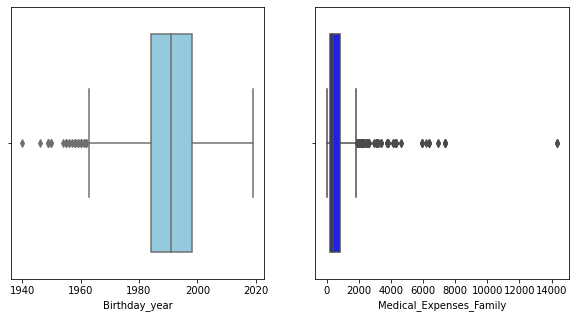

In [15]:
f, axes = plt.subplots(1,2, figsize=(10, 5), squeeze=False)    
sns.boxplot(df["Birthday_year"], color="skyblue", ax=axes[0, 0])
sns.boxplot(df["Medical_Expenses_Family"], color="blue", ax=axes[0, 1])

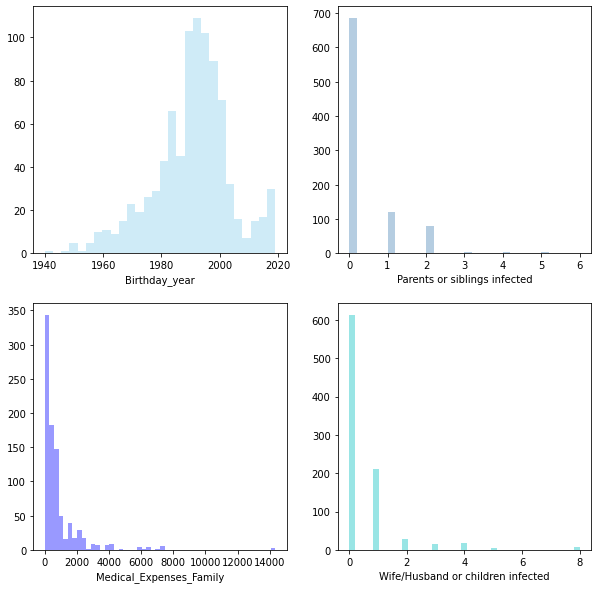

In [16]:
f, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.distplot(df["Birthday_year"], color="skyblue", ax=axes[0, 0], kde=False)
sns.distplot(df["Parents or siblings infected"], color="steelblue", ax=axes[0, 1], kde=False)
sns.distplot(df["Medical_Expenses_Family"], color="blue", ax=axes[1, 0], kde=False)
sns.distplot(df["Wife/Husband or children infected"], color="c", ax=axes[1, 1], kde=False)

In [17]:
df['Outlier'] = 0
df.loc[df['Medical_Expenses_Family']>13000, 'Outlier']=1
df['Outlier'].value_counts()

0    897
1      3
Name: Outlier, dtype: int64

In [18]:
df = df.loc[df['Outlier'] == 0]

<hr>
<a class="anchor" id="modify">

# 3. Modify
    
</a>

<hr>
<a class="anchor" id="transf_create">

## 3.1. Transform and Create variables
    
</a>

In [19]:
df.loc[df['City'] == 'Santa Fe', 'Santa Fe'] = 1
df.loc[df['City'] != 'Santa Fe', 'Santa Fe'] = 0
test_df.loc[test_df['City'] == 'Santa Fe', 'Santa Fe'] = 1
test_df.loc[test_df['City'] != 'Santa Fe', 'Santa Fe'] = 0

df.loc[df['City'] == 'Albuquerque', 'Albuquerque'] = 1
df.loc[df['City'] != 'Albuquerque', 'Albuquerque'] = 0
test_df.loc[test_df['City'] == 'Albuquerque', 'Albuquerque'] = 1
test_df.loc[test_df['City'] != 'Albuquerque', 'Albuquerque'] = 0

df.loc[df['City'] == 'Taos', 'Taos'] = 1
df.loc[df['City'] != 'Taos', 'Taos'] = 0
test_df.loc[test_df['City'] == 'Taos', 'Taos'] = 1
test_df.loc[test_df['City'] != 'Taos', 'Taos'] = 0

df['Age'] = 2020 - df['Birthday_year']
test_df['Age'] = 2020 - test_df['Birthday_year']

df['Family_cases'] = df['Parents or siblings infected'] + df['Wife/Husband or children infected']
test_df['Family_cases'] = test_df['Parents or siblings infected'] + test_df['Wife/Husband or children infected']

Family_size = pd.DataFrame(df['Patient_ID'].groupby(df['Family_Case_ID']).count())
Family_size = Family_size.rename({'Patient_ID':'Family_size'}, axis='columns') 
df = df.merge(Family_size, on = ['Family_Case_ID'])

Family_size_test = pd.DataFrame(test_df['Patient_ID'].groupby(test_df['Family_Case_ID']).count())
Family_size_test = Family_size_test.rename({'Patient_ID':'Family_size'}, axis='columns') 
test_df = test_df.merge(Family_size_test, on = ['Family_Case_ID'])

df['Medical_Expenses_Person'] = df['Medical_Expenses_Family']/df['Family_size']
test_df['Medical_Expenses_Person'] = test_df['Medical_Expenses_Family']/test_df['Family_size']

df.drop(columns = ['City','Name','Outlier','Family_Case_ID','Birthday_year'], inplace = True)
df.set_index('Patient_ID', inplace = True)

<hr>
<a class="anchor" id="coherence">

## 3.2. Coherence Checking
    
</a>

In [20]:
df2 = df.copy()
df2['Incoherent'] = 0
df2.loc[df2['Family_cases'] > df2['Family_size'], 'Incoherent'] = 1
df2.loc[(df['Age'] > 120) | (df2['Age'] < 0), 'Incoherent'] = 1
df2['Incoherent'].value_counts()

0    841
1     56
Name: Incoherent, dtype: int64

<hr>
<a class="anchor" id="corr">

## 3.3. Correlation Analysis
    
</a>

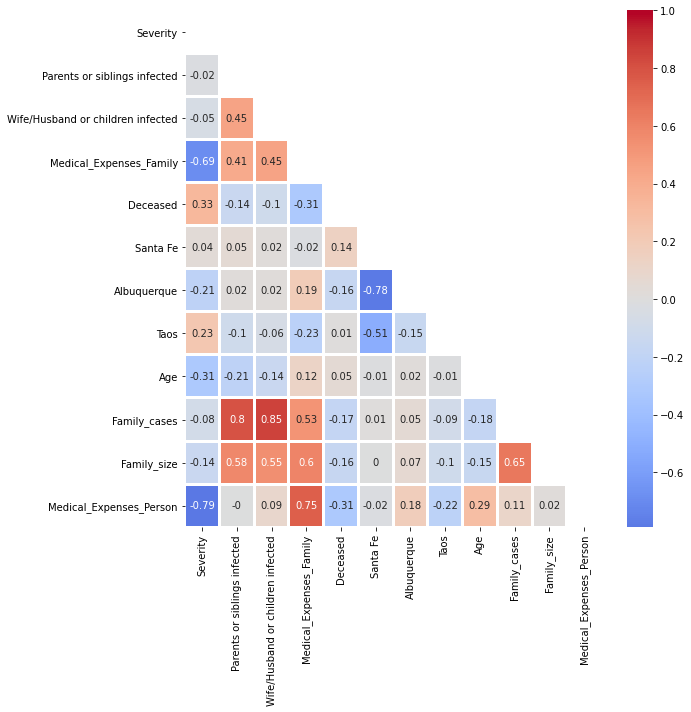

In [21]:
plt.rcParams['figure.figsize'] = (10,10)

corr_matrix=df.corr(method = 'spearman').round(2)
mask=np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(data=corr_matrix, mask=mask, center=0, annot=True, linewidths=2, cmap='coolwarm')
plt.tight_layout()

<hr>
<a class="anchor" id="datastand">

## 3.4. Data Standardization
    
</a>

In [22]:
X = df[['Severity', 'Age','Santa Fe', 'Albuquerque', 'Taos',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'Family_cases', 'Family_size', 'Medical_Expenses_Person']]

y = df['Deceased']

In [23]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X, columns = ['Severity', 'Age','Santa Fe', 'Albuquerque', 'Taos',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'Family_cases', 'Family_size', 'Medical_Expenses_Person'])
X

,Severity,Age,Santa Fe,Albuquerque,Taos,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Family_cases,Family_size,Medical_Expenses_Person
0,0.820356,0.035203,0.614720,-0.476536,-0.31292,-0.473022,-0.475670,-0.545106,-0.561184,-0.601393,-0.463141
1,-1.584413,1.848230,-1.626758,2.098479,-0.31292,-0.473022,0.434087,0.707545,0.060275,-0.601393,2.230094
2,0.820356,0.639545,0.614720,-0.476536,-0.31292,-0.473022,-0.475670,-0.548590,-0.561184,-0.601393,-0.470632
3,0.820356,-0.493597,0.614720,-0.476536,-0.31292,-0.473022,-0.475670,-0.549461,-0.561184,-0.601393,-0.472505
4,0.820356,-0.266968,0.614720,-0.476536,-0.31292,-0.473022,-0.475670,-0.547719,-0.561184,-0.601393,-0.468760
...,...,...,...,...,...,...,...,...,...,...,...
892,-0.382029,2.452573,-1.626758,-0.476536,3.19570,-0.473022,-0.475670,-0.505035,-0.561184,-0.601393,-0.376987
893,0.820356,-0.191426,0.614720,-0.476536,-0.31292,-0.473022,-0.475670,-0.529426,-0.561184,-0.601393,-0.429429
894,0.820356,-1.173482,0.614720,-0.476536,-0.31292,-0.473022,-0.475670,-0.516359,-0.561184,-0.601393,-0.401335
895,0.820356,0.035203,-1.626758,-0.476536,3.19570,-0.473022,-0.475670,-0.554688,-0.561184,-0.601393,-0.483743


<hr>
<a class="anchor" id="feature">

## 3.5. Feature Selection
    
</a>

<hr>
<a class="anchor" id="lasso">

### 3.5.1. Lasso Regression
    
</a>

In [24]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [25]:
reg = LassoCV()
reg.fit(X, y)
coef = pd.Series(reg.coef_, index=X.columns)
coef.sort_values()

Medical_Expenses_Family             -0.013147
Parents or siblings infected        -0.009815
Albuquerque                         -0.000000
Taos                                -0.000000
Wife/Husband or children infected    0.000000
Family_cases                         0.000000
Family_size                          0.000000
Medical_Expenses_Person             -0.000000
Santa Fe                             0.035843
Age                                  0.064234
Severity                             0.150274
dtype: float64

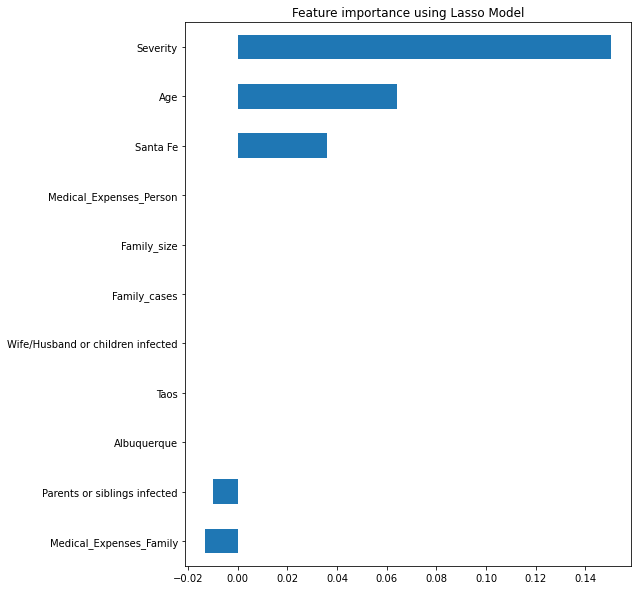

In [26]:
plot_importance(coef, 'Lasso')

<hr>
<a class="anchor" id="rfe">

### 3.5.3. Recursive Feature Elimination (RFE)
    
</a>

In [27]:
#no of features
nof_list=np.arange(1,22)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    # we are going to see in the next class this "train_test_split()"...
    X_train_rfe, X_rfe_val, y_train_rfe, y_rfe_val = train_test_split(X,y, test_size = 0.3, random_state = 100)
    
    model_rfe = LogisticRegression()
    rfe = RFE(model_rfe,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_rfe,y_train_rfe)
    X_rfe_val = rfe.transform(X_rfe_val)
    model_rfe.fit(X_train_rfe,y_train_rfe)
    
    score = model_rfe.score(X_rfe_val,y_rfe_val)
    score_list.append(score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 3
Score with 3 features: 0.681481


<hr>
<a class="anchor" id="model">

# 4. Model
    
</a>

In [ ]:
Variables = ['Severity', 'Age', 'Santa Fe', 'Taos', 'Parents or siblings infected', 
             'Wife/Husband or children infected', 'Medical_Expenses_Family', 'Family_size']
X = X.loc[:,Variables]

<hr>
<a class="anchor" id="knn">

## 4.1. K Nearest Neighbors
    
</a>

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=15)

knn_clf = KNeighborsClassifier(random_state=15)

knn_parameters = {'n_neighbors' : (3, 5, 10),
                  'metric' : ['euclidean', 'cosine', 'manhattan']}

knn_grid = GridSearchCV(estimator=knn_clf, param_grid=knn_parameters, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)

knn_grid.fit(X, y)
knn_grid.best_params_

In [ ]:
knn_grid.best_score_

<hr>
<a class="anchor" id="knc">

## 4.2. K Nearest Centroid
    
</a>

In [ ]:
knc_clf = NearestCentroid(random_state=15)

knc_parameters = {'metric' : ['euclidean', 'cosine', 'manhattan']}

knc_grid = GridSearchCV(estimator=knc_clf, param_grid=knc_parameters, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)

knc_grid.fit(X, y)
knc_grid.best_params_

In [ ]:
knc_grid.best_score_

<hr>
<a class="anchor" id="rf">

## 4.3. Random Forest
    
</a>

In [ ]:
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=15)

rf_parameters = {"n_estimators": np.arange(100, 400, 100),
                 "max_features": ['sqrt', 'log2', 'auto', None],
                 "criterion": ['gini', 'entropy'],
                 "warm_start" : [True, False]}

rf_grid = GridSearchCV(estimator=rf_clf, param_grid=rf_parameters, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)

rf_grid.fit(X, y)
rf_grid.best_params_

In [ ]:
rf_grid.best_score_

<hr>
<a class="anchor" id="dt">

## 4.4. Decision Tree
    
</a>

In [ ]:
dt_clf = DecisionTreeClassifier(class_weight='balanced', random_state=15)

dt_parameters = {"max_features": ['sqrt', 'log2', 'auto', None],
                 "splitter" : ['best', 'random'],
                 "criterion": ['gini', 'entropy'],
                 "warm_start" : [True, False]}

dt_grid = GridSearchCV(estimator=rf_clf, param_grid=rf_parameters, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)

dt_grid.fit(X, y)
dt_grid.best_params_

In [ ]:
dt_grid.best_score_

<hr>
<a class="anchor" id="pa">

## 4.5. Passive Aggressive
    
</a>

In [ ]:
pa_clf = PassiveAggressiveClassifier(class_weight='balanced', random_state=15)

pa_parameters = {"warm_start" : [True, False],
                 "early_stopping" : [True, False],
                 "max_iter" : (100, 500, 1000)}

pa_grid = GridSearchCV(estimator=pa_clf, param_grid=pa_parameters, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)

pa_grid.fit(X, y)
pa_grid.best_params_

In [ ]:
pa_grid.best_score_